In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from funcs.ffd import FFD, _get_multistar_factors

import time
tstamp = time.strftime("%d_%m_%Y_%H_%M", time.localtime())

In [2]:
df = pd.read_csv("../flare_tables/20200225_vetted_flares.csv",
                names=['ampl_rec','cstart','cstop','ed_rec','ed_rec_err',
                    'istart', 'istop','total_n_valid_data_points', 
                    'tstart', 'tstop',  'dur', 'ed_ratio','ed_ratio_count',
            'amplitude_ratio','amplitude_ratio_count','duration_ratio','duration_ratio_count',
            'amplitude_corr','duration_corr','ed_corr','recovery_probability','recovery_probability_count',
            'ed_ratio_std','amplitude_ratio_std','duration_ratio_std','recovery_probability_std',
            'ed_corr_err','amplitude_corr_err','duration_corr_err',"TIC","sector"])
              
spts = pd.read_csv("../flare_tables/spts.csv")

spts.head()
df = df.merge(spts[["TIC","spt","TESSmag"]],on="TIC")
df.head()

,ampl_rec,cstart,cstop,ed_rec,ed_rec_err,istart,istop,total_n_valid_data_points,tstart,tstop,...,amplitude_ratio_std,duration_ratio_std,recovery_probability_std,ed_corr_err,amplitude_corr_err,duration_corr_err,TIC,sector,spt,TESSmag
0,0.205888,134304,134309,67.120761,3.173210,2025,2030,14656,1413.993959,1414.000903,...,0.216691,0.861911,0.480091,19.234675,0.076164,0.004110,141306513,4,M7,14.114
1,0.046567,137530,137534,15.629983,1.373603,5211,5215,14656,1418.474567,1418.480123,...,0.106518,0.179538,0.233295,18.366493,0.006369,0.078722,141306513,4,M7,14.114
2,0.432789,142823,142831,158.509751,2.815147,7029,7037,14656,1425.825985,1425.837096,...,1.313973,0.560077,0.398147,73.540852,0.715953,0.001228,141306513,4,M7,14.114
3,0.184068,146868,146872,54.249658,2.487500,11047,11051,14656,1431.444002,1431.449558,...,0.216691,0.861911,0.427976,15.533675,0.068093,0.003288,141306513,4,M7,14.114
4,0.149158,289806,289811,52.999981,2.495028,3262,3267,18704,1629.964562,1629.971506,...,0.124189,0.329367,0.492076,27.150836,0.021153,0.013543,358108509,12,M6,14.351


In [ ]:
totobs = df.groupby(["TIC","sector"]).total_n_valid_data_points.apply(lambda x: x.iloc[0]).sum()/30./24./365.25

In [ ]:
totobs

In [ ]:
plt.hist(df.recovery_probability_count, bins=np.linspace(0,50,10), histtype="step");

In [ ]:
plt.hist(df.ed_ratio_count, bins=np.linspace(0,50,10), histtype="step");

In [ ]:
plt.scatter(df.ampl_rec, df.amplitude_corr)
plt.plot([0,12],[0,12])

In [ ]:
plt.hist(df.amplitude_ratio_count, bins=np.linspace(0,300,10), histtype="step");

In [ ]:
plt.hist(df.duration_ratio_count, bins=np.linspace(0,300,10), histtype="step");

In [ ]:
plt.scatter(df.ed_rec, df.ed_corr)
plt.plot([1,3e3],[1,3e3])
plt.yscale("log")
plt.xscale("log")

In [ ]:
plt.hist(df.recovery_probability, bins=np.linspace(0,1,6), histtype="step");

In [ ]:
#correct for magnitudes
plt.figure(figsize=(6.5,5.5))
plt.hist(df.TESSmag, bins=20);


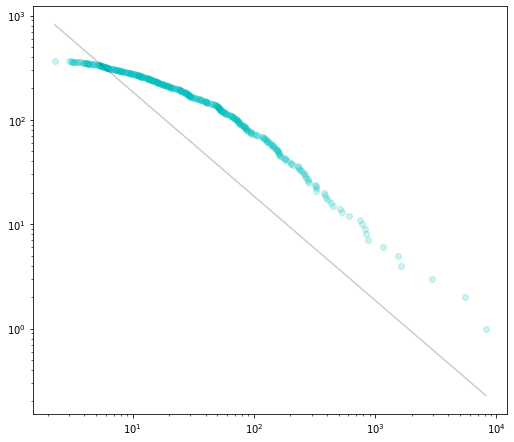

In [3]:
df = df[~np.isnan(df.recovery_probability) & (df.recovery_probability > 0.2)]
df = df.sort_values(by="ed_corr", ascending=False)
df = df[~df.ed_corr.isnull() & np.isfinite(df.ed_corr) & (df.ed_corr > 6)]

ffd = FFD(df,ID="TIC")
ffd.alpha, ffd.alpha_err = 2., .2
ffd.tot_obs_time = 1.

fig, ax = plt.subplots(1,figsize=(8.5,7.5))

# No correction, single star mode
ed, freq, counts = ffd.ed_and_freq( energy_correction=False,
                            recovery_probability_correction=False,
                             multiple_stars=False)
ax.scatter(ed, freq, c="c", label="no correction",alpha=.2)
_beta, ffd.beta, beta_err = ffd.fit_beta_to_powerlaw(ed,freq, mode="ED")
ffd.plot_powerlaw(ax, ed, c="k", alpha=.2,)
plt.xscale('log')
plt.yscale('log')

In [ ]:
a, sig_a = ffd.fit_powerlaw(df.ed_rec.values)
ispowerlaw = ffd.is_powerlaw(df.ed_rec.values)
truncated = ffd.is_powerlaw_truncated(df.ed_rec.values)

print(a, sig_a, ispowerlaw, truncated)

In [36]:
ed, freq, counts = ffd.ed_and_freq( energy_correction=True,
                            recovery_probability_correction=True,
                             multiple_stars=True)
eds = []
for n, ED in zip(np.rint((1/counts)*56), df.ed_rec.sort_values(ascending=True)):
    eds.append(int(n)*[ED])
eds =[i  for a in eds for i in a]

In [37]:
len(eds)

6992

In [34]:
a, sig_a = ffd.fit_powerlaw(eds)
a, sig_a

(1.5604937353018378, 0.007570189182408835)

In [ ]:
ffd.alpha = a
ffd.alpha_err = sig_a

In [35]:
ispowerlaw = ffd.is_powerlaw(np.array(eds))
ispowerlaw

AttributeError: 'list' object has no attribute 'shape'

In [26]:
truncated = ffd.is_powerlaw_truncated(eds)

print(a, sig_a, ispowerlaw, truncated)

KeyboardInterrupt: 

In [ ]:
_get_multistar_factors(df, "TIC", "ed_corr")


In [ ]:
# ED correction, single star mode
ed, freq = ffd.ed_and_freq( energy_correction=True,
                            recovery_probability_correction=False,
                             multiple_stars=False)
ax.scatter(ed, freq, c="c", label="ED correction",alpha=.5)
_beta, beta, beta_err = ffd.fit_beta_to_powerlaw(ed,freq, mode="ED")
ffd.plot_powerlaw(ax, ed, c="k",alpha=.5, )


# ED and recprob correction, single star mode
ed, freq = ffd.ed_and_freq( energy_correction=True,
                            recovery_probability_correction=True,
                             multiple_stars=False)
ax.scatter(ed, freq, c="c",alpha=1, label="ED and recprob correction")
_beta, beta, beta_err = ffd.fit_beta_to_powerlaw(ed,freq, mode="ED")
ffd.plot_powerlaw(ax, ed, c="k",alpha=1, )




# No correction, multiple star mode
ed, freq = ffd.ed_and_freq( energy_correction=False,
                            recovery_probability_correction=False,
                             multiple_stars=True)
ax.scatter(ed, freq, c="r", label="no correction",alpha=.2)
_beta, beta, beta_err = ffd.fit_beta_to_powerlaw(ed,freq, mode="ED")
ffd.plot_powerlaw(ax, ed, c="k", alpha=.2, )

# ED correction, multiple star mode
ed, freq = ffd.ed_and_freq( energy_correction=True,
                            recovery_probability_correction=False,
                             multiple_stars=True)
ax.scatter(ed, freq, c="r", label="ED correction",alpha=.5)
_beta, beta, beta_err = ffd.fit_beta_to_powerlaw(ed,freq, mode="ED")
ffd.plot_powerlaw(ax, ed, c="k",alpha=.5, )


# ED and recprob correction, multiple star mode
ed, freq = ffd.ed_and_freq( energy_correction=True,
                            recovery_probability_correction=True,
                             multiple_stars=True)
ax.scatter(ed, freq, c="r",alpha=1, label="ED and recprob correction")
_beta, beta, beta_err = ffd.fit_beta_to_powerlaw(ed,freq, mode="ED")
ffd.plot_powerlaw(ax, ed, c="k",alpha=1, )


plt.xscale('log')
plt.yscale('log')
plt.xlabel("ED [s]")#"flare energy in TESS band [erg]")
plt.ylabel("cumulative number of flares per year")
# #plt.title(spt)
plt.legend(fontsize=14)
# #     plt.figure(figsize=(6.5,5.5))
# #     plt.hist(df.TESSmag)
# #     plt.title(spt)

# plt.ylim(.1,1e3)
# plt.xlim(1,10000)
# # for x,z in zip(a,f):
# #     print(x,z)
# # print(df.shape)
# plt.savefig(f"../plots/{tstamp}_FFD_two_step_correction.png".format(tstamp), dpi=300)

In [ ]:
ed, freq = ffd.ed_and_freq( energy_correction=True,
                            recovery_probability_correction=True,
                             multiple_stars=True)
ffd.is_powerlaw(ed),  ffd.is_powerlaw_truncated(ed)

In [ ]:
#df = df[df.recovery_probability > .2]


df = df.sort_values(by="ed_rec", ascending=False)
#df['probnocorrcum'] = np.cumsum(1/np.array(freq[::-1])*freq[-1])
df['probnocorrcum'] = np.cumsum(np.ones_like(freq))
df['sortededrec'] =df.ed_rec.sort_values(ascending=False)
df = df.sort_values(by="ed_corr", ascending=False)
df = df[(~df.ed_corr.isnull()) & (np.isfinite(df.ed_corr)) & (df.recovery_probability >0.0) ]
df["ed_corrprob"] = 1/df.recovery_probability.values
df["ed_corrprob_err"] = df.recovery_probability_std / df.recovery_probability**2
df["ed_corrprobcum"] = np.cumsum(df.ed_corrprob.values)


plt.figure(figsize=(6.5,5.5))
for l, row in df.iterrows():
    plt.plot([row.sortededrec, row.ed_corr], [row.probnocorrcum, row.ed_corrprobcum],c="grey",alpha=.5)
plt.scatter(df["sortededrec"], df["probnocorrcum"], label="no correction", c="k")#, condition {}".format(label))
plt.scatter(df.ed_corr, df["ed_corrprobcum"], label="energy ratio and recovery probability correction", c="r")#, condition {}".format(label))
plt.plot([10, 4000],[4000, 10], label="slope=-1", linestyle="dashed", c="grey", linewidth=3)
plt.xscale('log')
plt.yscale('log')
#plt.ylim(.8,250)
#plt.xlim(5,4000)
plt.xlabel("ED [s]")#"flare energy in TESS band [erg]")
plt.ylabel("cumulative number of flares")
plt.legend()
#plt.savefig("plots/{}_FFD_flare_correspondence_correction.png".format(today), dpi=300)

In [ ]:
f
